In [1]:
from rdkit import Chem
import chemlib
from chemlib import Element

import numpy as np
import pandas as pd
import os
from functools import partial

from ray import train
from ray import tune
from ray.tune.schedulers import ASHAScheduler

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import global_mean_pool, GraphConv, NNConv, EdgeConv
from torch_geometric.loader import DataLoader
device = 'cuda:0'
from ray.tune.search.hyperopt import HyperOptSearch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

2025-02-19 11:08:29,490	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-02-19 11:08:29,729	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] Не найдена указанная процедура
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] Не найдена указанная процедура
  warnings.warn(f"An issue occurred while importi

In [2]:
#abs_path is made for function "load_data" so that is doesn't lose table with descriptors
path = os.path.abspath('') + '\\grouped_table.csv'

The function "load_data" according to its name, loads data from table with structures and target values. Actually, it unites loading from .csv file, creating .mol column, dropping all above 95% percentile and creating train, validation and test datasets

In [3]:
def load_data(abs_path = path, variable = 'Tc'):
    df = pd.read_csv(abs_path, index_col = 0)
    df = df[~df[variable].isnull()]
    df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
    quant = df[variable].quantile(q= 0.95)
    mask = df[variable] < quant
    df = df[mask]

    train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 0)
    
    valid_df, test_df = train_test_split(test_df, test_size = 0.5, random_state = 0)
    return train_df, test_df, valid_df

In the cell below we check that function works and create test dataset, that will be useful in the end

In [4]:
train_df, test_df, valid_df = load_data()

Functions below and class CriticalDataset and GraphNet are taken from *model_architecture_search.ipynb* and are well-described there. Please, refer to this file. 

In [5]:
def make_edge_features(mol):
    edge_features = np.zeros([mol.GetNumBonds(), 4])
    for i, bond in enumerate(mol.GetBonds()):
        if bond.GetBondTypeAsDouble() == 1.0:
            edge_features[i,0] = 1
        elif bond.GetBondTypeAsDouble() == 2.0:
            edge_features[i,1] = 1
        elif bond.GetBondTypeAsDouble() == 3.0:
            edge_features[i, 2] = 1
        else:
            edge_features[i, 3] = 1
    return torch.tensor(edge_features, dtype = torch.float32)

In [6]:
def make_x(mol):
    atom_properties = []
    
    for atom in mol.GetAtoms():
        _el = Element(atom.GetSymbol())
        atom_properties.append([atom.GetAtomicNum(), atom.GetMass(), int(atom.GetIsAromatic()), atom.GetExplicitValence(), 
                                atom.GetImplicitValence(), atom.GetTotalValence(), 
                                atom.GetNumExplicitHs(), atom.GetNumImplicitHs(), atom.GetTotalNumHs(),
                                atom.GetDegree(), atom.GetTotalDegree(), atom.GetFormalCharge(),
                               int(atom.IsInRing()), _el.Electronegativity, _el.FirstIonization, _el.AtomicRadius, _el.SpecificHeat
                               ])
    x = torch.tensor(atom_properties, dtype = torch.float32)
    return x

In [7]:
def make_edge_indices(mol):
    start_atoms = []
    end_atoms = []
    for bond in mol.GetBonds():
        start_atoms.append(bond.GetBeginAtomIdx())
        end_atoms.append(bond.GetEndAtomIdx())
    edge_indice = torch.tensor([start_atoms, end_atoms], dtype = torch.int64)
    return edge_indice

In [8]:
class CriticalDataset(Dataset):
    def __init__(self, frame, labels = None, transform = None, property = 'Tc'):
        super().__init__()
        self.property = property    
        self.df = frame[~frame[self.property].isnull()]
        self.labels = None
        self.transform = None
    def get(self, idx):
        mol = self.df['mol'].iloc[idx]
        #print(Chem.MolToSmiles(mol))
        try:
            x = make_x(mol)
        except:
            print('Invalid mol - cannot make x')
        try:
            edge_indices = make_edge_indices(mol)
        except:
            print('Invalid mol - cannot make edge indice')
        try:
            edge_features = make_edge_features(mol)
        except:
            print('Invalid mol - cannot make edge features')
        y = torch.tensor(self.df[self.property].iloc[idx], dtype = torch.float32)
        data = Data(x=x, edge_index=edge_indices, y = y, edge_features = edge_features)
        return data
    def len(self):
        return(len(self.df))

This is the optimal acrhitecture, that we found earlier, in *model_architecture_search.ipynb*. However, we want to vary number of neurons on convolutional layers, which is crucial for good prediction. Therefore, when creating the class, we leave a space to do it, using parameters *n1*, *n2*, *n3*, *n4*. Other architecture features are the same

In [9]:
class GraphNet(nn.Module):
    def __init__(self, num_node_features = 17,
                n1 = 200,
                n2 = 500,
                n3 = 500,
                n4 = 500):
        super().__init__()
        conv_1_nn = nn.Sequential(nn.Linear(4, 200), nn.ReLU(), nn.Linear(200, 17*n1))
        self.conv_1 = NNConv(17, n1, nn = conv_1_nn)
        self.a1_con = nn.ReLU()
        
        conv_2_nn = nn.Sequential(nn.Linear(2*n1, n2), nn.ReLU(), nn.Linear(n2, n2))
        self.conv_2 = EdgeConv(nn = conv_2_nn)
        self.a2_con = nn.ReLU()
        
        conv_3_nn = nn.Sequential(nn.Linear(2*n2, n3), nn.ReLU(), nn.Linear(n3, n3))
        self.conv_3 = EdgeConv(nn = conv_3_nn)
        self.a3_con = nn.ReLU()
        
        self.conv_4 = GraphConv(in_channels = n3, out_channels = n4)
        self.a4_con = nn.ReLU()
        self.dropout_1 = nn.Dropout(p = 0.3)
        self.a1 = nn.CELU()
        self.linear_1 = nn.Linear(in_features = n4, out_features = 1000)
        self.a2 = nn.CELU()
        self.linear_2 = nn.Linear(in_features = 1000, out_features = 1000)
        self.a3 = nn.CELU()
        self.linear_3 = nn.Linear(in_features = 1000, out_features = 1)
    def forward(self, data):
        x, edge_index, edge_attrs =  (data.x, data.edge_index, data.edge_features)
        x = self.a1_con(self.conv_1(x = x, edge_index = edge_index, edge_attr = edge_attrs))
        x = self.a2_con(self.conv_2(x = x, edge_index = edge_index))
        x = self.a3_con(self.conv_3(x = x, edge_index = edge_index))
        x = self.a4_con(self.conv_4(x = x, edge_index = edge_index))
        if hasattr(data, 'batch'):
            x = global_mean_pool(x, batch = data.batch)
        else:
            x = torch.mean(x, dim = 0, keepdim = True)
        #x = self.a1(x)
        x = self.dropout_1(x)
        x = self.linear_1(x)
        x = self.a2(x)
        x = self.linear_2(x)
        x = self.a3(x)
        x = self.linear_3(x)
        return x


Ths config file is used here just to define the function)

In [11]:
config = {
    "n1": tune.qrandint(100, 1000, 100),
    "n2": tune.qrandint(100, 1000, 100),
    "n3": tune.qrandint(100, 1000, 100),
    "n4": tune.qrandint(100, 1000, 100),
    "n_epochs": tune.qrandint(1, 50, 5),
    "lr": tune.loguniform(1e-4, 1e-2)}

This function is crucial for the search of optimal hyperparameters. It has following arguments:
1. Config - dictionary with learning rate ('lr') and number of neurons in first and second linear layers ('l1' and 'l2')
2. abs_path - is the path of *table_with_descriptors.csv* - second cell of this Notebook
3.  Is_tune - flags if this function is used in Ray Tune instance to find optimal hyperparameters (True) or in model training with known hyperparameters (False)

In [29]:
def train_model(config = config, 
                abs_path  = path,
                variable = 'Tc',
                is_tune = True):
    #first we create train, test and validation dataset
    train_df, test_df, valid_df = load_data(abs_path = abs_path, variable = variable)
    #if is_tune is True, i.e. our goal is to determine optimal model hyperparameters, three datasets are created
    if is_tune:
        train_ds, test_ds,  valid_ds = (CriticalDataset(train_df, property = variable), 
                                        CriticalDataset(test_df, property = variable), 
                                        CriticalDataset(valid_df,property = variable))
        train_dl, test_dl, valid_dl = (DataLoader(train_ds, batch_size=2), DataLoader(test_ds, batch_size =2),  DataLoader(valid_ds, batch_size=2))
    #if is_tune is false, i.e. our goal is to get trained model, training and validation datasets are concatenated
    else:
        train_df = pd.concat([train_df, test_df])
        train_ds, valid_ds = (CriticalDataset(train_df, property = variable), 
                              CriticalDataset(valid_df, property = variable))
        train_dl, valid_dl = (DataLoader(train_ds, batch_size = 2), DataLoader(valid_ds, batch_size = 2))
        
    #here we instantiate the model with n1, n2, n3, n4 from config - search space
    model = GraphNet(n1 = config['n1'], n2 = config['n2'], n3 = config['n3'], n4 = config['n4'])
    model.to(device)
    optimizer = torch.optim.Adam(params = model.parameters(), lr = config['lr'])
    loss_fn = nn.MSELoss()
    #number of training epochs is also parameter to vary
    for epoch in range(config['n_epochs']):
        # perform the training-validation loop and assess all metrics
        epoch_train_loss, epoch_valid_loss, epoch_train_rmse, epoch_valid_rmse, epoch_r2_valid, total_graphs = 0, 0, 0, 0, 0, 0
        model.train()
        for batch in train_dl:
            batch.to(device)
            output = model(batch)
            loss = loss_fn(output.flatten(), batch.y)
            #obligatory step! if not zeroed, graph training will just return average value
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            epoch_train_rmse += (output.flatten() -batch.y).pow(2).sum().item()
            total_graphs += batch.num_graphs
            
        epoch_train_loss = epoch_train_loss / total_graphs
        epoch_train_rmse = np.sqrt(epoch_train_rmse/total_graphs)
        
        model.eval()
        total_graphs = 0
        #predictions and ys are used after loop to calculate r2 value
        predictions = []
        ys = []
        for batch in valid_dl:
            batch.to(device)
            output = model(batch)
            loss = loss_fn(output.flatten(), batch.y)
            epoch_valid_loss += loss.item()
            epoch_valid_rmse += (output.flatten() -batch.y).pow(2).sum().item()
            total_graphs += batch.num_graphs
            predictions.append(output)
            ys.append(batch.y)
            
        predictions = torch.cat(predictions, dim = 0).detach().cpu().numpy()
        ys = torch.cat(ys, dim = 0).detach().cpu().numpy()
        epoch_valid_loss = epoch_valid_loss / total_graphs
        epoch_valid_rmse = np.sqrt(epoch_valid_rmse / total_graphs)
        epoch_r2_valid = r2_score(ys, predictions.squeeze())
         #if our goal is not to use function in tune run, we print validation metrics on every step
        if not is_tune:
            print('vali loss is:', epoch_valid_loss, ' valid rmse is: ', epoch_valid_rmse, ' R2 valid is ',  epoch_r2_valid)
        #if our goal is to use function in tune run, we report all metrics on every step
        if is_tune:
            train.report({'train_loss':epoch_train_loss,
                          'train_rmse':epoch_train_rmse,
                          'valid_loss':epoch_valid_loss,
                          'valid_rmse':epoch_valid_rmse,
                          'r2_valid':epoch_r2_valid})
    #if our goal is not to use function in tune run, in the end of the training we return trained model and draw predicted vs real values
    if not is_tune:
        sns.scatterplot(x = predictions.squeeze(), y = ys)
        return model
        

Here we check that function works well for just model training

C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 20.341428431654986  valid rmse is:  6.378311442953375  R2 valid is  0.6333572864532471


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 13.245494094910859  valid rmse is:  5.146939691682983  R2 valid is  0.7612574100494385


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 10.820166350594125  valid rmse is:  4.6519170995610235  R2 valid is  0.8049726486206055


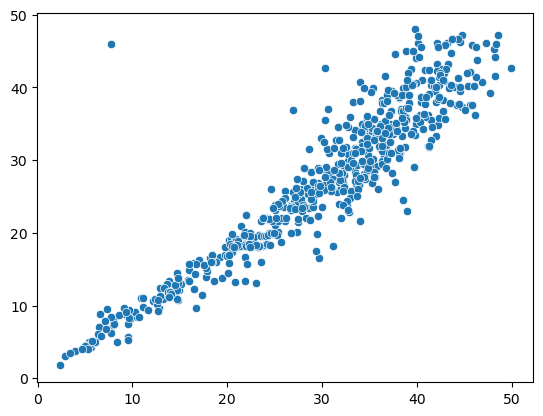

In [30]:
config = {
    "n1": 200,
    "n2": 500,
    "n3": 500,
    "n4": 500,
    "n_epochs": 3,
    "lr": 0.0001}
model = train_model(config = config, is_tune = False, variable = 'Pc')

Instantiate config with search space

In [31]:
config = {
    "n1": tune.qrandint(100, 1000, 100),
    "n2": tune.qrandint(100, 1000, 100),
    "n3": tune.qrandint(100, 1000, 100),
    "n4": tune.qrandint(100, 1000, 100),
    "n_epochs": tune.qrandint(1, 50, 5),
    "lr": tune.loguniform(1e-4, 1e-2)}

Instantiate algorithm (from HyperOpt), maximum number of epochs, scheduler and run the Ray Tune

In [35]:
hpt_search = HyperOptSearch(metric = 'valid_loss', mode = 'min')

In [36]:
max_num_epochs = 50
scheduler = ASHAScheduler(metric = 'valid_loss', mode = 'min', max_t = max_num_epochs, grace_period= 5, reduction_factor=2)

In [37]:
result = tune.run(partial(train_model, variable = 'Pc'), search_alg = hpt_search, config = config, num_samples = 25, scheduler = scheduler, resources_per_trial={'gpu':1})

2025-02-19 11:39:07,284	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(pid=10532) Windows fatal exception: code 0xc0000139
(pid=10532) 
(pid=10532) Stack (most recent call first):
(pid=10532)   File "C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\ctypes\__init__.py", line 376 in __init__
(pid=10532)   File "C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch\_ops.py", line 1350 in load_library
(pid=10532)   File "C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_scatter\__init__.py", line 16 in <module>
(pid=10532)   File "<frozen importlib._bootstrap>", line 241 in _call_with_frames_removed
(pid=10532)   File "<frozen importlib._bootstrap_external>", line 940 in exec_module
(pid=10532)   File "<frozen importlib._bootstrap>", line 690 in _load_unlocked
(pid=10532)   File "<frozen importlib._bootstrap>", line 1147 in _find_and_load_unlocked
(pid=10532)   File "<frozen importlib._bootstrap>", line 1176 in _find_and_load
(pid=10532)   File "C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geo

Trial name,r2_valid,train_loss,train_rmse,valid_loss,valid_rmse
train_model_08818ec0,0.939442,3.66494,2.70737,3.35977,2.59221
train_model_16ec11ce,-0.167195,53.1512,10.3103,64.7563,11.3804
train_model_1e25f3ac,0.886675,5.76347,3.39513,6.28731,3.54607
train_model_1f145aed,0.902771,6.80174,3.68829,5.39428,3.28459
train_model_22ba2c8a,0.862494,4.79519,3.09683,7.62886,3.90611
train_model_241ca6b0,0.729042,20.8058,6.45071,15.0328,5.48321
train_model_26327fa1,-0.126477,67.3544,11.6064,62.4972,11.1801
train_model_2d3559d8,0.359303,41.0541,9.06136,35.546,8.43161
train_model_2f0bfff8,-0.135306,53.8484,10.3777,62.987,11.2238
train_model_2f236c26,0.888176,6.32842,3.55764,6.20404,3.52251


(func pid=10532) C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
(func pid=10532)   warnings.warn(message)
(func pid=10532) C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
(func pid=10532)   warnings.warn(message)
(func pid=10532) C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
(func pid=10532)   warnings.warn(message)
(func pid=10532) C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')`

Let's print DataFrame with all metrics for the Ray Tune run

In [38]:
result.dataframe()

,train_loss,train_rmse,valid_loss,valid_rmse,r2_valid,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,...,node_ip,time_since_restore,iterations_since_restore,config/n1,config/n2,config/n3,config/n4,config/n_epochs,config/lr,logdir
0,3.001565,2.450129,2.191350,2.093490,0.960502,1739956266,None,False,30,f0b7fd59,...,127.0.0.1,1913.904392,30,700,500,300,700,30,0.000416,f0b7fd59
1,53.151173,10.310303,64.756253,11.380356,-0.167195,1739956600,None,True,5,16ec11ce,...,127.0.0.1,327.980817,5,100,400,500,1000,45,0.005798,16ec11ce
2,4.956551,3.148508,3.507161,2.648456,0.936785,1739957955,None,True,20,4f10e986,...,127.0.0.1,1349.617062,20,300,700,200,800,20,0.001056,4f10e986
3,20.805849,6.450713,15.032823,5.483215,0.729042,1739958271,None,True,5,241ca6b0,...,127.0.0.1,310.137053,5,400,500,800,500,5,0.001958,241ca6b0
4,67.354379,11.606410,62.497233,11.180092,-0.126477,1739958594,None,True,5,26327fa1,...,127.0.0.1,317.943913,5,900,600,600,700,30,0.002939,26327fa1
5,6.801745,3.688291,5.394275,3.284593,0.902771,1739958919,None,False,5,1f145aed,...,127.0.0.1,319.052772,5,800,200,900,1000,5,0.000195,1f145aed
6,53.197525,10.314798,69.014117,11.748542,-0.243940,1739959263,None,True,5,e85a80b0,...,127.0.0.1,338.637858,5,500,500,400,300,35,0.002135,e85a80b0
7,5.294283,3.254008,7.013526,3.745271,0.873585,1739959893,None,True,10,d3ededbd,...,127.0.0.1,624.029531,10,900,300,500,800,25,0.000292,d3ededbd
8,34.408396,8.295589,13.924641,5.277242,0.749016,1739960266,None,True,5,98406a41,...,127.0.0.1,367.888652,5,400,200,500,600,20,0.002134,98406a41
9,7.807937,3.951693,5.985674,3.459964,0.892112,1739961692,None,True,20,f13d2982,...,127.0.0.1,1419.975192,20,800,100,300,300,30,0.002104,f13d2982


Save the Result instance

In [39]:
with open('pressure_result.pickle', 'wb') as out:
    pickle.dump(result, out)

Get best config, print it and save it

In [40]:
best_config = result.get_best_config(metric = 'valid_rmse', mode = 'min')
print(best_config)
with open('best_config_pressure.pickle', 'wb') as out:
    pickle.dump(best_config, out)

{'n1': 300, 'n2': 200, 'n3': 400, 'n4': 300, 'n_epochs': 45, 'lr': 0.00037787236069767406}


Let's train the model. For the best config, RMSE after final step for the test set (which we got earlier) is 2.02, $R^{2}$  is 0.96. Much better than for omega

C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 20.22785984363152  valid rmse is:  6.360481089293721  R2 valid is  0.6354042291641235


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 12.679471312703546  valid rmse is:  5.035766339437036  R2 valid is  0.771459698677063


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 8.394888765933993  valid rmse is:  4.097533103205877  R2 valid is  0.8486868739128113


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 7.001981945738731  valid rmse is:  3.7421870465648106  R2 valid is  0.8737932443618774


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 6.4959992511798585  valid rmse is:  3.6044414965927407  R2 valid is  0.8829132914543152


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 5.7299370555683415  valid rmse is:  3.3852435822458453  R2 valid is  0.8967211246490479


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 5.055931031025934  valid rmse is:  3.179915417436739  R2 valid is  0.9088696837425232


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 4.499669748291689  valid rmse is:  2.999889914077411  R2 valid is  0.9188960194587708


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 4.021191157898122  valid rmse is:  2.8359094336378665  R2 valid is  0.9275202751159668


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 5.092620940272642  valid rmse is:  3.1914325749646166  R2 valid is  0.9082083702087402


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 4.4635147170106055  valid rmse is:  2.987813487154312  R2 valid is  0.9195476770401001


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 3.3905933239293993  valid rmse is:  2.6040711679711825  R2 valid is  0.9388864636421204


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 4.032285600803574  valid rmse is:  2.8398188677461715  R2 valid is  0.9273203611373901


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 3.1034718152250886  valid rmse is:  2.491373843976487  R2 valid is  0.9440616965293884


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 3.339587948568687  valid rmse is:  2.584410164261349  R2 valid is  0.939805805683136


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 3.01088188808557  valid rmse is:  2.453928233704307  R2 valid is  0.9457305669784546


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.9521451023951815  valid rmse is:  2.429874524495115  R2 valid is  0.9467892646789551


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 3.5000377316725615  valid rmse is:  2.6457655722578903  R2 valid is  0.936913788318634


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.8136776808910193  valid rmse is:  2.37220474701954  R2 valid is  0.9492850303649902


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.6626957845551806  valid rmse is:  2.307680993792331  R2 valid is  0.9520063996315002


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.9733796603522635  valid rmse is:  2.4385978185638826  R2 valid is  0.9464064836502075


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.6305021203277748  valid rmse is:  2.293687912654106  R2 valid is  0.9525867104530334


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.7942585145708794  valid rmse is:  2.364004447783836  R2 valid is  0.9496350884437561


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.3832037605167784  valid rmse is:  2.1832103703110146  R2 valid is  0.9570441246032715


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.4633864714424294  valid rmse is:  2.2196335154445785  R2 valid is  0.9555988311767578


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 3.116764581801691  valid rmse is:  2.496703659548602  R2 valid is  0.9438220858573914


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.2005806747635868  valid rmse is:  2.0978945039079475  R2 valid is  0.9603357911109924


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.529960880924588  valid rmse is:  2.2494269852229425  R2 valid is  0.9543988704681396


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.335376471996987  valid rmse is:  2.1611924819399992  R2 valid is  0.9579061269760132


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.39612134996383  valid rmse is:  2.1891191607419773  R2 valid is  0.956811249256134


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.119855279757426  valid rmse is:  2.059055744635111  R2 valid is  0.9617908000946045


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.6687680712851  valid rmse is:  2.3103108324574424  R2 valid is  0.9518969655036926


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.163146397175119  valid rmse is:  2.079974229251468  R2 valid is  0.9610105156898499


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.292929162134808  valid rmse is:  2.141461726080953  R2 valid is  0.9586712718009949


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.085759988166877  valid rmse is:  2.042429919564868  R2 valid is  0.9624053239822388


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.445509579525339  valid rmse is:  2.211564866570881  R2 valid is  0.9559210538864136


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.6444903253061933  valid rmse is:  2.299778391630895  R2 valid is  0.9523345232009888


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.068163309361579  valid rmse is:  2.0337961104110605  R2 valid is  0.9627225399017334


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 1.8652794805419075  valid rmse is:  1.931465495701079  R2 valid is  0.9663794040679932


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 1.8677755757750707  valid rmse is:  1.9327573959372504  R2 valid is  0.9663344025611877


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 1.7111818619136523  valid rmse is:  1.8499631682353312  R2 valid is  0.9691569209098816


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.004805863163728  valid rmse is:  2.002401489793557  R2 valid is  0.9638645052909851


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.007579007076785  valid rmse is:  2.003785920240376  R2 valid is  0.9638144969940186


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.0449262944896516  valid rmse is:  2.022338396257981  R2 valid is  0.9631413817405701


C:\Users\Timur\anaconda3\envs\ChemInfo-Pytorch\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


vali loss is: 2.0545335812243883  valid rmse is:  2.027083412799971  R2 valid is  0.9629681706428528


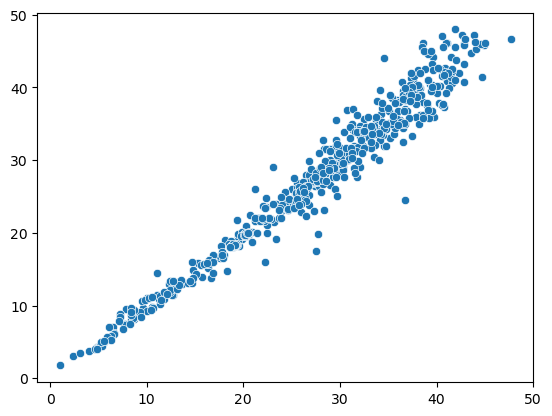

In [41]:
model = train_model(config = best_config, variable = 'Pc', is_tune = False)

Let's save a model to use it in calculator

In [42]:
torch.save(model, 'pressure_model.pth')